In [2]:
import numpy as np
import pandas as pd
from io import StringIO
import seaborn as sns
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torchtext
from transformers import BertTokenizer, AdamW
from transformers.models.bert.modeling_bert import BertModel

d:\jswietek\mgr\env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
with open('../data/data_bcr_clinical_data_sample.txt', 'r') as f:
	bcr_sample_df = pd.read_csv(StringIO(''.join(f.readlines()[4:]).replace('[Not Available]', '')), sep='\t')
	print(bcr_sample_df.columns)

Index(['PATIENT_ID', 'SAMPLE_ID', 'OTHER_SAMPLE_ID', 'SPECIMEN_CURRENT_WEIGHT',
       'DAYS_TO_COLLECTION', 'DAYS_TO_SPECIMEN_COLLECTION',
       'SPECIMEN_FREEZING_METHOD', 'INITIAL_WEIGHT',
       'SPECIMEN_SECOND_LONGEST_DIMENSION', 'IS_FFPE', 'LONGEST_DIMENSION',
       'METHOD_OF_SAMPLE_PROCUREMENT', 'OCT_EMBEDDED',
       'OTHER_METHOD_OF_SAMPLE_PROCUREMENT', 'PATHOLOGY_REPORT_FILE_NAME',
       'PATHOLOGY_REPORT_UUID', 'SAMPLE_TYPE', 'SAMPLE_TYPE_ID',
       'SHORTEST_DIMENSION', 'TIME_BETWEEN_CLAMPING_AND_FREEZING',
       'TIME_BETWEEN_EXCISION_AND_FREEZING', 'VIAL_NUMBER', 'ONCOTREE_CODE',
       'CANCER_TYPE', 'CANCER_TYPE_DETAILED'],
      dtype='object')


In [4]:
with open('../data/data_bcr_clinical_data_patient 1.txt', 'r') as f:
	bcr_patient_df = pd.read_csv(StringIO(''.join(f.readlines()[4:]).replace('[Not Available]', '')), sep='\t')
	for col in bcr_patient_df.columns:
		print(col)
     

OTHER_PATIENT_ID
PATIENT_ID
FORM_COMPLETION_DATE
PROSPECTIVE_COLLECTION
RETROSPECTIVE_COLLECTION
DAYS_TO_BIRTH
GENDER
MENOPAUSE_STATUS
RACE
ETHNICITY
HISTORY_OTHER_MALIGNANCY
HISTORY_NEOADJUVANT_TRTYN
TUMOR_STATUS
VITAL_STATUS
DAYS_TO_LAST_FOLLOWUP
DAYS_TO_DEATH
RADIATION_TREATMENT_ADJUVANT
PHARMACEUTICAL_TX_ADJUVANT
HISTOLOGICAL_SUBTYPE
INITIAL_PATHOLOGIC_DX_YEAR
AGE
METHOD_OF_INITIAL_SAMPLE_PROCUREMENT
METHOD_OF_INITIAL_SAMPLE_PROCUREMENT_OTHER
SURGICAL_PROCEDURE_FIRST
FIRST_SURGICAL_PROCEDURE_OTHER
PATH_MARGIN
SURGERY_FOR_POSITIVE_MARGINS
SURGERY_FOR_POSITIVE_MARGINS_OTHER
MARGIN_STATUS_REEXCISION
STAGING_SYSTEM
STAGING_SYSTEM_OTHER
MICROMET_DETECTION_BY_IHC
LYMPH_NODES_EXAMINED
LYMPH_NODE_EXAMINED_COUNT
LYMPH_NODES_EXAMINED_HE_COUNT
LYMPH_NODES_EXAMINED_IHC_COUNT
AJCC_STAGING_EDITION
AJCC_TUMOR_PATHOLOGIC_PT
AJCC_NODES_PATHOLOGIC_PN
AJCC_METASTASIS_PATHOLOGIC_PM
AJCC_PATHOLOGIC_TUMOR_STAGE
METASTATIC_SITE
METASTATIC_SITE_OTHER
ER_STATUS_BY_IHC
ER_STATUS_IHC_PERCENT_POSITIVE
ER_POSI

In [4]:
for i, o in enumerate(bcr_patient_df.isna().sum()):
    print(bcr_patient_df.columns[i], o)

OTHER_PATIENT_ID 0
PATIENT_ID 0
FORM_COMPLETION_DATE 0
PROSPECTIVE_COLLECTION 4
RETROSPECTIVE_COLLECTION 4
DAYS_TO_BIRTH 16
GENDER 0
MENOPAUSE_STATUS 90
RACE 95
ETHNICITY 174
HISTORY_OTHER_MALIGNANCY 0
HISTORY_NEOADJUVANT_TRTYN 1
TUMOR_STATUS 125
VITAL_STATUS 0
DAYS_TO_LAST_FOLLOWUP 105
DAYS_TO_DEATH 0
RADIATION_TREATMENT_ADJUVANT 931
PHARMACEUTICAL_TX_ADJUVANT 932
HISTOLOGICAL_SUBTYPE 0
INITIAL_PATHOLOGIC_DX_YEAR 2
AGE 1
METHOD_OF_INITIAL_SAMPLE_PROCUREMENT 95
METHOD_OF_INITIAL_SAMPLE_PROCUREMENT_OTHER 4
SURGICAL_PROCEDURE_FIRST 54
FIRST_SURGICAL_PROCEDURE_OTHER 821
PATH_MARGIN 68
SURGERY_FOR_POSITIVE_MARGINS 1041
SURGERY_FOR_POSITIVE_MARGINS_OTHER 0
MARGIN_STATUS_REEXCISION 1037
STAGING_SYSTEM 216
STAGING_SYSTEM_OTHER 1076
MICROMET_DETECTION_BY_IHC 367
LYMPH_NODES_EXAMINED 377
LYMPH_NODE_EXAMINED_COUNT 126
LYMPH_NODES_EXAMINED_HE_COUNT 168
LYMPH_NODES_EXAMINED_IHC_COUNT 751
AJCC_STAGING_EDITION 141
AJCC_TUMOR_PATHOLOGIC_PT 0
AJCC_NODES_PATHOLOGIC_PN 0
AJCC_METASTASIS_PATHOLOGIC_PM 0


In [5]:
# print(bcr_patient_df[bcr_patient_df['PR_STATUS_BY_IHC'].isna() == True]['NTE_PR_STATUS_BY_IHC'])
print('IHC_HER2\n', bcr_patient_df['IHC_HER2'].value_counts(), '\n')
print('PR_STATUS_BY_IHC\n', bcr_patient_df['PR_STATUS_BY_IHC'].value_counts(), '\n')
print('ER_STATUS_BY_IHC\n', bcr_patient_df['ER_STATUS_BY_IHC'].value_counts(), '\n')
print('ER_STATUS_BY_IHC\n', bcr_patient_df['NTE_PR_STATUS_BY_IHC'].value_counts(), '\n')
print('HER2_FISH_STATUS\n', bcr_patient_df['HER2_FISH_STATUS'].value_counts(), '\n')

IHC_HER2
 Negative         563
Equivocal        179
Positive         164
Indeterminate     12
Name: IHC_HER2, dtype: int64 

PR_STATUS_BY_IHC
 Positive         698
Negative         344
Indeterminate      4
Name: PR_STATUS_BY_IHC, dtype: int64 

ER_STATUS_BY_IHC
 Positive         807
Negative         238
Indeterminate      2
Name: ER_STATUS_BY_IHC, dtype: int64 

ER_STATUS_BY_IHC
 Negative    7
Positive    4
Name: NTE_PR_STATUS_BY_IHC, dtype: int64 

HER2_FISH_STATUS
 Negative         333
Positive          78
Equivocal          5
Indeterminate      4
Name: HER2_FISH_STATUS, dtype: int64 



In [6]:
bcr_patient_df[bcr_patient_df['IHC_HER2'] == 'Equivocal']['NTE_HER2_STATUS'].isna().sum()

175

In [7]:
raw_exams_df = pd.read_csv('../data/TCGA_Reports.csv')
patients_df = pd.read_excel('../data/TCGA-CDR-SupplementalTableS1.xlsx')
raw_exams_df['bcr_patient_barcode'] = raw_exams_df['patient_filename'].map(lambda x: x.split('.')[0])
tmp_exams_df = pd.concat([patients_df[patients_df['type'] == 'BRCA'].set_index('bcr_patient_barcode'), raw_exams_df.set_index('bcr_patient_barcode')], axis=1, join='inner')[['text', 'patient_filename']]
tmp_exams_df

,text,patient_filename
bcr_patient_barcode,,
TCGA-3C-AAAU,Path No.: Date Obtained: (Age: Date Received: ...,TCGA-3C-AAAU.0CD23E1B-3FA3-4A43-AE6E-C8E7B51252F8
TCGA-3C-AALI,Path No.: Date Obtained: (Age: ). Date Receive...,TCGA-3C-AALI.84E6A935-1A49-4BC1-9669-3DEA161CF6FC
TCGA-3C-AALJ,Path No.: Date Obtained: (Age: ). Date Receive...,TCGA-3C-AALJ.265E5A9A-64FD-4B86-89BC-5E89F253C118
TCGA-3C-AALK,Path No.: Date Obtained: (Age: ). Date Receive...,TCGA-3C-AALK.F43B01E6-E1DB-44B1-8003-93870606346A
TCGA-4H-AAAK,Procedure: Left radical mastectomy. Preoperati...,TCGA-4H-AAAK.8894688F-7167-48A1-BB1B-FC219B7675C2
...,...,...
TCGA-WT-AB41,SURG PATH #: SPECIMEN CLASS: ALT ID #: SEX: F....,TCGA-WT-AB41.FDB00212-9782-4ACE-AD59-019384297A2F
TCGA-WT-AB44,SURG PATH #: SPECIMEN CLASS: ALT ID #: SEX: F....,TCGA-WT-AB44.B7EB0E0B-46C5-43C0-A78D-FB094290765A
TCGA-XX-A89A,Research Gross Description. Research Dx. Left ...,TCGA-XX-A89A.5D85E578-64B4-4238-922E-802B8ED87800


In [8]:
(tmp_exams_df['text'].apply(lambda x: len(x.split(" "))) < 512).value_counts()

True     556
False    478
Name: text, dtype: int64

In [9]:
exams_df = pd.concat([bcr_patient_df.set_index('PATIENT_ID'), tmp_exams_df], axis=1, join='inner')

In [10]:
exams_df[['text', 'PR_STATUS_BY_IHC', 'NTE_PR_STATUS_BY_IHC', 'NTE_ER_STATUS', 'ER_STATUS_BY_IHC', 'IHC_HER2', 'HER2_FISH_STATUS', 'NTE_HER2_STATUS']]

,text,PR_STATUS_BY_IHC,NTE_PR_STATUS_BY_IHC,NTE_ER_STATUS,ER_STATUS_BY_IHC,IHC_HER2,HER2_FISH_STATUS,NTE_HER2_STATUS
TCGA-3C-AALI,Path No.: Date Obtained: (Age: ). Date Receive...,Positive,NaN,NaN,Positive,Positive,NaN,NaN
TCGA-3C-AALJ,Path No.: Date Obtained: (Age: ). Date Receive...,Positive,NaN,NaN,Positive,Indeterminate,NaN,NaN
TCGA-3C-AALK,Path No.: Date Obtained: (Age: ). Date Receive...,Positive,NaN,NaN,Positive,Positive,NaN,NaN
TCGA-4H-AAAK,Procedure: Left radical mastectomy. Preoperati...,Positive,NaN,NaN,Positive,Equivocal,NaN,NaN
TCGA-5L-AAT0,Gender: Female. Color: White. Origin: Nature o...,Positive,NaN,NaN,Positive,Negative,NaN,NaN
...,...,...,...,...,...,...,...,...
TCGA-WT-AB41,SURG PATH #: SPECIMEN CLASS: ALT ID #: SEX: F....,Positive,NaN,NaN,Positive,NaN,NaN,NaN
TCGA-WT-AB44,SURG PATH #: SPECIMEN CLASS: ALT ID #: SEX: F....,Positive,NaN,NaN,Positive,Negative,NaN,NaN
TCGA-XX-A89A,Research Gross Description. Research Dx. Left ...,Positive,NaN,NaN,Positive,Negative,NaN,NaN
TCGA-Z7-A8R5,ADDENDUM. Addendum #1. Entered. BREAST CANCER ...,Positive,NaN,NaN,Positive,Negative,NaN,NaN


In [5]:
statuses = ['Negative', 'Positive']

In [6]:
def get_status_code(status: str):
    if status == 'Negative': return 0
    elif status == 'Positive': return 1
    else: return np.nan

In [7]:
def get_er_status(row: pd.Series):
    if row['ER_STATUS_BY_IHC'] in statuses:
        return get_status_code(row['ER_STATUS_BY_IHC'])
    if row['NTE_ER_STATUS'] in statuses:
        return get_status_code(row['NTE_ER_STATUS'])

    return np.nan

In [8]:
def get_her2_status(row: pd.Series):
    if row['IHC_HER2'] in statuses:
        return get_status_code(row['IHC_HER2'])
    if row['HER2_FISH_STATUS'] in statuses:
        return get_status_code(row['HER2_FISH_STATUS'])
    if row['NTE_HER2_STATUS'] in statuses:
        return get_status_code(row['NTE_HER2_STATUS'])
    return np.nan

In [9]:
def get_pr_status(row: pd.Series):
    if row['PR_STATUS_BY_IHC'] in statuses:
        return get_status_code(row['PR_STATUS_BY_IHC'])
    if row['NTE_PR_STATUS_BY_IHC'] in statuses:
        return get_status_code(row['NTE_PR_STATUS'])

    return np.nan

In [10]:
def get_hr_status(row: pd.Series):
    if row['ER'] == 1 or row['PR'] == 1:
        return 1
    if row['ER'] == 0 and row['PR'] == 0:
        return 0

    return np.nan

In [17]:
def get_cancer_subtype2(row: pd.Series):
    if row['HR'] == 0 and row['HER2'] == 0: return "TNBC"
    if row['HR'] == 1 and row['HER2'] == 0: return "Luminal A"
    if row['HR'] == 1 and row['HER2'] == 1: return "Luminal B"
    if row['HR'] == 0 and row['HER2'] == 1: return "HER2+"
    return np.nan

In [12]:
def get_cancer_subtype(row: pd.Series):
    if row['HR'] == 0 and row['HER2'] == 0: return "TNBC"
    if row['HR'] == 1 and row['HER2'] == 0: return "HR+"
    if row['HER2'] == 1: return "HER2+"
    return np.nan

In [13]:
def get_targets(row: pd.Series):
    if row['HR'] == 1 and row['HER2'] == 0: return [1, 0, 0]
    if row['HR'] == 1 and row['HER2'] == 1: return [0, 1, 0]
    if row['HR'] == 0: return [0, 0, 1]
    return np.nan

In [21]:
bcr_patient_df
bcr_patient_df['HER2'] = bcr_patient_df.apply(get_her2_status, axis=1)
bcr_patient_df['ER'] = bcr_patient_df.apply(get_er_status, axis=1)
bcr_patient_df['PR'] = bcr_patient_df.apply(get_pr_status, axis=1)
bcr_patient_df['HR'] = bcr_patient_df.apply(get_hr_status, axis=1)
bcr_patient_df['subtype2'] = bcr_patient_df.apply(get_cancer_subtype2, axis=1)
bcr_patient_df['subtype'] = bcr_patient_df.apply(get_cancer_subtype, axis=1)

In [24]:
bcr_patient_df['subtype'].shape

(1096,)

In [19]:
exams_df['HER2'] = exams_df.apply(get_her2_status, axis=1)
exams_df['ER'] = exams_df.apply(get_er_status, axis=1)
exams_df['PR'] = exams_df.apply(get_pr_status, axis=1)
exams_df['HR'] = exams_df.apply(get_hr_status, axis=1)

In [21]:
missing_df = exams_df[(exams_df['HER2'].isna()) | (exams_df['HR'].isna())]
missing_df.index.to_series().to_csv('./negative_df.csv')

In [22]:
rna_seq_df = pd.read_excel('../data/BRCA_predicted_subtypes.xlsx', index_col='patients_id')
# rna_seq_df = rna_seq_df.apply(get_new_rna_row, axis=1)
rna_seq_df

,subtype
patients_id,
TCGA-C8-A27A,HR+
TCGA-AR-A0TW,HR+
TCGA-A1-A0SH,HR+
TCGA-A2-A0EW,HR+
TCGA-GM-A2DN,HR+
...,...
TCGA-E9-A229,HR+
TCGA-A8-A08P,HER2+
TCGA-A8-A09W,HR+


In [23]:
def get_new_missing_row(row: pd.Series):
    # print(row)
    her2 = row['HER'] if np.isnan(row['HER2']) else row['HER2']
    hr = row['HR_rna'] if np.isnan(row['HR']) else row['HR']

    return pd.Series({'HER2': her2, 'HR': hr})

<AxesSubplot:>

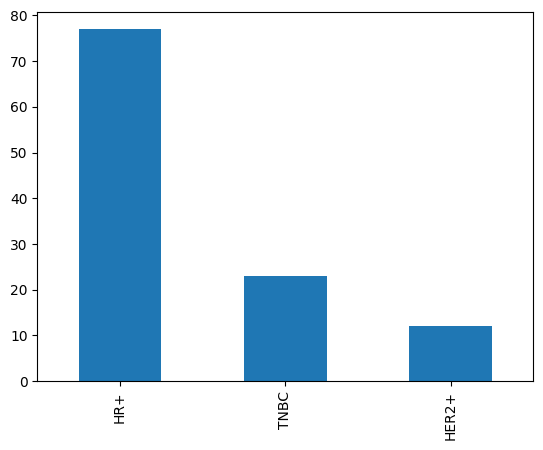

In [24]:
missing_rna_df = pd.merge(missing_df, rna_seq_df, left_index=True, right_index=True, suffixes=(None, '_rna'))
# print(missing_rna_df.head())
# missing_rna_df = missing_rna_df.apply(get_new_missing_row, axis=1).apply(get_cancer_subtype, axis=1)
missing_rna_df['subtype'].value_counts().plot(kind='bar')

C:\Users\jswietek\AppData\Local\Temp\2\ipykernel_5796\774475314.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['SUBTYPE'] = df.apply(get_cancer_subtype, axis=1)


<AxesSubplot:>

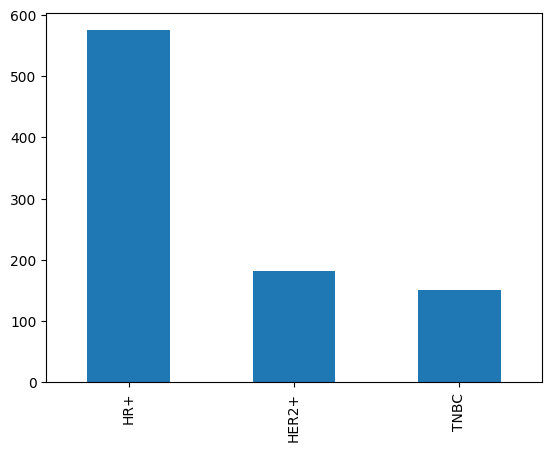

In [25]:
df = exams_df[(~exams_df['HER2'].isna()) & (~exams_df['HR'].isna())]
df['SUBTYPE'] = df.apply(get_cancer_subtype, axis=1)
# df.to_csv('../data/processed_df2.csv')
df['SUBTYPE'].value_counts().plot(kind='bar')

In [26]:
df['SUBTYPE'].value_counts()

HR+      575
HER2+    181
TNBC     151
Name: SUBTYPE, dtype: int64

In [27]:
def get_train_test_split(df: pd.DataFrame, group_sample_size: int=50, target_column: str="SUBTYPE", same_train_classes_count: bool = False):
    test_df = pd.DataFrame(columns=df.columns)
    for c in df[target_column].unique():
        test_df = pd.concat([df[df[target_column] == c].sample(group_sample_size, random_state=420).loc[:], test_df.loc[:]])
    train_df = df.loc[~df.index.isin(test_df.index)]
    
    if same_train_classes_count:
        train_df2 = pd.DataFrame(columns=df.columns)
        max_sample = np.min(df['SUBTYPE'].value_counts().iloc[0:3].to_numpy())
        for c in df[target_column].unique():
            train_df2 = pd.concat([df[df[target_column] == c].sample(max_sample, random_state=420).loc[:], train_df2.loc[:]])
        train_df = train_df2

    return train_df, test_df

train_df, test_df = get_train_test_split(df, group_sample_size=30)
print(train_df.shape, test_df.shape)
train_df.head()

(817, 121) (90, 121)


,OTHER_PATIENT_ID,FORM_COMPLETION_DATE,PROSPECTIVE_COLLECTION,RETROSPECTIVE_COLLECTION,DAYS_TO_BIRTH,GENDER,MENOPAUSE_STATUS,RACE,ETHNICITY,HISTORY_OTHER_MALIGNANCY,...,OS_MONTHS,DFS_STATUS,DFS_MONTHS,text,patient_filename,HER2,ER,PR,HR,SUBTYPE
TCGA-3C-AALI,55262FCB-1B01-4480-B322-36570430C917,2014-7-28,NO,YES,-18538.0,FEMALE,Post (prior bilateral ovariectomy OR >12 mo si...,BLACK OR AFRICAN AMERICAN,NOT HISPANIC OR LATINO,No,...,131.57,DiseaseFree,131.57,Path No.: Date Obtained: (Age: ). Date Receive...,TCGA-3C-AALI.84E6A935-1A49-4BC1-9669-3DEA161CF6FC,1.0,1.0,1.0,1.0,HER2+
TCGA-3C-AALK,C31900A4-5DCD-4022-97AC-638E86E889E4,2014-7-28,NO,YES,-19074.0,FEMALE,NaN,BLACK OR AFRICAN AMERICAN,NOT HISPANIC OR LATINO,No,...,47.57,DiseaseFree,47.57,Path No.: Date Obtained: (Age: ). Date Receive...,TCGA-3C-AALK.F43B01E6-E1DB-44B1-8003-93870606346A,1.0,1.0,1.0,1.0,HER2+
TCGA-5L-AAT0,86C6F993-327F-4525-9983-29C55625593A,2014-8-15,NO,YES,-15393.0,FEMALE,Post (prior bilateral ovariectomy OR >12 mo si...,WHITE,HISPANIC OR LATINO,Yes,...,48.52,DiseaseFree,48.52,Gender: Female. Color: White. Origin: Nature o...,TCGA-5L-AAT0.F9B6971F-23C0-465F-BFEC-778BF228A1AE,0.0,1.0,1.0,1.0,HR+
TCGA-A1-A0SB,0045349c-69d9-4306-a403-c9c1fa836644,2011-6-30,NO,YES,-25833.0,FEMALE,Post (prior bilateral ovariectomy OR >12 mo si...,WHITE,NOT HISPANIC OR LATINO,No,...,8.51,DiseaseFree,8.51,Final Pathologic Diagnosis: A. Sentinel lymph ...,TCGA-A1-A0SB.BEC7EEA9-6DEA-4402-A3A1-07EF33D58174,0.0,1.0,0.0,1.0,HR+
TCGA-A1-A0SD,c462e422-eb8d-4daf-9897-2a9c6cbd783a,2011-9-7,NO,YES,-21793.0,FEMALE,NaN,WHITE,NOT HISPANIC OR LATINO,No,...,14.36,DiseaseFree,14.36,Final Pathologic Diagnosis: A. Sentinel lymph ...,TCGA-A1-A0SD.DD89D265-9E20-49C2-93BD-666BE7D5E41B,0.0,1.0,1.0,1.0,HR+


In [28]:
from textaugment import Wordnet
from textaugment import Translate, EDA
import albumentations as A
from nlpaug.augmenter import sentence, char

translate_aug = Translate(src="en", to="fr")
eda = EDA()
shuffle_aug = sentence.RandomSentAug(mode='random')
cont_aug = sentence.AbstSummAug(max_length = 3000, device = 'cuda')

def augment_data(df: pd.DataFrame, types_to_augment: list[str]):
    res = df.copy()

    for ty in types_to_augment:
        translated_df = df[df['SUBTYPE'] == ty].copy()
        # shufled_df = df[df['SUBTYPE'] == ty].copy()
        translated_df['text'] = translated_df['text'].apply(lambda x: translate_aug.augment(x))
        # shufled_df['text'] = pd.concat((shufled_df, translated_df)) translated_df['text'].apply(lambda x: shuffle_aug.augment(x))
        res = pd.concat((res, translated_df))
    return res

augmented_train_df = augment_data(train_df, ['HER2+', 'TNBC'])

def sentence_aug(df: pd.DataFrame):
    res = df.copy()

    shufled_df = res.copy()
    shufled_df['text'] = shufled_df['text'].apply(lambda x: shuffle_aug.augment(x)[0])
    return pd.concat((res, shufled_df))

augmented_train_df2 = sentence_aug(augmented_train_df)

random_aug = char.RandomCharAug()
def char_aug(df: pd.DataFrame):
    res = df.copy()

    shufled_df = res.copy()
    shufled_df['text'] = shufled_df['text'].apply(lambda x: random_aug.augment(x)[0])
    return pd.concat((res, shufled_df))

augmented_train_df3 = char_aug(augmented_train_df2)

d:\jswietek\mgr\env\lib\site-packages\transformers\models\t5\tokenization_t5_fast.py:160: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-base automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(


In [29]:
def contextual_aug(df: pd.DataFrame):
    res = df.copy()

    shufled_df = res.copy()
    shufled_df['text'] = shufled_df['text'].apply(lambda x: cont_aug.augment(x)[0])
    return pd.concat((res, shufled_df))

augmented_train_df4 = contextual_aug(augmented_train_df3)

augmented_train_df1 = augmented_train_df
augmented_train_df = augmented_train_df3

Token indices sequence length is longer than the specified maximum sequence length for this model (1753 > 512). Running this sequence through the model will result in indexing errors


OutOfMemoryError: CUDA out of memory. Tried to allocate 2.97 GiB. GPU 0 has a total capacty of 12.00 GiB of which 2.21 GiB is free. Of the allocated memory 6.89 GiB is allocated by PyTorch, and 99.41 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [33]:
augmented_train_df3[['text', 'HER2', 'ER', 'PR', 'HR', 'SUBTYPE']]

,text,HER2,ER,PR,HR,SUBTYPE
TCGA-3C-AALI,Path No.: Date Obtained: (Age: ). Date Receive...,1.0,1.0,1.0,1.0,HER2+
TCGA-3C-AALK,Path No.: Date Obtained: (Age: ). Date Receive...,1.0,1.0,1.0,1.0,HER2+
TCGA-5L-AAT0,Gender: Female. Color: White. Origin: Nature o...,0.0,1.0,1.0,1.0,HR+
TCGA-A1-A0SB,Final Pathologic Diagnosis: A. Sentinel lymph ...,0.0,1.0,0.0,1.0,HR+
TCGA-A1-A0SD,Final Pathologic Diagnosis: A. Sentinel lymph ...,0.0,1.0,1.0,1.0,HR+
...,...,...,...,...,...,...
TCGA-OL-A66I,final pathological diagnosis. axillary tumpect...,0.0,0.0,0.0,0.0,TNBC
TCGA-OL-A6VO,final pathological diagnosis. a. sentinel lymp...,0.0,0.0,0.0,0.0,TNBC
TCGA-OL-A97C,final pathological diagnosis. there is a 25 x ...,0.0,0.0,0.0,0.0,TNBC
TCGA-S3-AA10,"temporary copy. diagnostic. a. right breast, m...",0.0,0.0,0.0,0.0,TNBC


In [34]:
# augmented_train_df3[['text', 'HER2', 'ER', 'PR', 'HR', 'SUBTYPE']].to_csv('../data/augmented_train_df3.csv')

In [35]:
# test_df[['text', 'HER2', 'ER', 'PR', 'HR', 'SUBTYPE']].to_csv('../data/test_30.csv')

In [64]:
from nlpaug.augmenter import word
print(len(augmented_train_df3['text'][0]))
wc_aug = word.ContextualWordEmbsAug(model_path='C:/Users/jswietek/.cache/huggingface/hub/models--bert-base-uncased/snapshots/1dbc166cf8765166998eff31ade2eb64c8a40076', device='cuda')
wc_aug.augment(augmented_train_df3['text'][0])

5596


['path informed. : date obtained : ( age : ). date received : f. see addendum / procedure. specimen : a : lymph node, right axilla sentinel node, biopsy. b : breast, right, lumpectomy. c : lymph nodes, right axilla, dissection. diagnosis ( es ) : a. deep node, right axilla sentinel node, biopsy : - carcinoma in 1 sentinel node following carcinoma of right breast. b. breast, right, lumpectomy : - carcinoma, single ductal type, moderately - differentiated, with focal micropapillary features,. nottingham\'s score 5 ( 2 + 2 + 1 ). - carcinoma, intraductal, comedo type with microcalcifications. - lobular neoplasia, focal, classical type. - fibrocystic disease, proliferative, with apocrine metaplasia, sclerosing point and. microcalcifications. - cicatricial fibrosis and organizing granulation tissue with fat necrosis, consistent with previous. biopsy site. - fibroadenoma, microscopic. c. lymph nodes, right axilla, dissection : - no evidence of carcinoma in 2 lymph nodes. date dictated : clin

In [65]:
def context_augment_data(df: pd.DataFrame, types_to_augment: list[str]):
    res = df.copy()

    for ty in types_to_augment:
        translated_df = df[df['SUBTYPE'] == ty].copy()
        # shufled_df = df[df['SUBTYPE'] == ty].copy()
        translated_df['text'] = translated_df['text'].apply(lambda x: wc_aug.augment(x))
        # shufled_df['text'] = pd.concat((shufled_df, translated_df)) translated_df['text'].apply(lambda x: shuffle_aug.augment(x))
        res = pd.concat((res, translated_df))
    return res
c_augmented_df = context_augment_data(augmented_train_df,  ['HER2+', 'TNBC'])

In [66]:
c_augmented_df['SUBTYPE'].value_counts()

HER2+    604
HR+      545
TNBC     484
Name: SUBTYPE, dtype: int64

In [70]:
sentence_aug_df = sentence_aug(c_augmented_df)
sentence_aug_df['SUBTYPE'].value_counts()

HER2+    1208
HR+      1090
TNBC      968
Name: SUBTYPE, dtype: int64

In [73]:
char_aug_df = char_aug(sentence_aug_df)
print(char_aug_df['SUBTYPE'].value_counts())

HER2+    2416
HR+      2180
TNBC     1936
Name: SUBTYPE, dtype: int64


In [75]:
# char_aug_df.to_csv('../data/char_aug_df.csv')
# sentence_aug_df.to_csv('../data/sentence_aug_df.csv')

In [52]:
import pandas as pd
rna_seq_df = pd.read_excel('../data/BRCA_predicted_subtypes.xlsx', index_col='patients_id')
negative_df = pd.read_csv('./negative_df.csv',  index_col=0)
negative_df = negative_df.join(rna_seq_df, how='inner')[['subtype']]
raw_exams_df = pd.read_csv('../data/TCGA_Reports.csv')

# rna_seq_df = rna_seq_df.apply(get_new_rna_row, axis=1)
negative_df

,subtype
TCGA-3C-AALJ,HR+
TCGA-4H-AAAK,HR+
TCGA-5L-AAT1,HR+
TCGA-A2-A25E,HR+
TCGA-A7-A0CH,HR+
...,...
TCGA-E9-A5UP,HER2+
TCGA-EW-A6SD,HER2+
TCGA-PL-A8LV,TNBC
TCGA-PL-A8LX,HR+


In [56]:
raw_exams_df['patient_id'] = raw_exams_df['patient_filename'].apply(lambda x: x.split('.')[0])
raw_exams_df.set_index('patient_id', inplace=True)

In [57]:
negative_df.join(raw_exams_df, how='inner')

,subtype,patient_filename,text
TCGA-3C-AALJ,HR+,TCGA-3C-AALJ.265E5A9A-64FD-4B86-89BC-5E89F253C118,Path No.: Date Obtained: (Age: ). Date Receive...
TCGA-4H-AAAK,HR+,TCGA-4H-AAAK.8894688F-7167-48A1-BB1B-FC219B7675C2,Procedure: Left radical mastectomy. Preoperati...
TCGA-5L-AAT1,HR+,TCGA-5L-AAT1.B5CA42BB-9514-42C6-9FB0-C8889C1DC51A,Gender: Female. Color: White. Origin: Nature o...
TCGA-A2-A25E,HR+,TCGA-A2-A25E.B81555D4-78D9-4235-AABE-F852CA6F15B5,Specimen #: (Age: F Race: Physician (s) : AMEN...
TCGA-A7-A0CH,HR+,TCGA-A7-A0CH.F70DA7E5-2AB3-487F-8B2C-72EEE91E58E0,SPECIMEN. A. Sentinel node left breast. B. Lef...
...,...,...,...
TCGA-E9-A5UP,HER2+,TCGA-E9-A5UP.B50AB6D5-3010-450E-9CCE-E9BFA0202736,Gross Description: There is a quadrant of the ...
TCGA-EW-A6SD,HER2+,TCGA-EW-A6SD.9FB40DC5-BED9-420E-B334-4D0BE8B8BCF5,F. Pathologic Interpretation: A. LEFT BREAST L...
TCGA-PL-A8LV,TNBC,TCGA-PL-A8LV.D35DBECD-5241-4562-85CC-2822BB338279,Sex: Female. Date of Tumour Procurement: 1. GR...
TCGA-PL-A8LX,HR+,TCGA-PL-A8LX.E6DD0840-4D71-4EEC-B559-F6BFC9E7E68B,Sex: Female. Date of Tumour Procurement: 1. GR...


In [10]:
len(negative_df.index), len(negative_df.index.unique())

(126, 126)

In [11]:
len(rna_seq_df.index), len(rna_seq_df.index.unique())

(981, 966)

In [43]:
non_unique_rna_index = rna_seq_df.index.unique()[rna_seq_df.index.value_counts() > 1]
non_unique_negative_index = negative_df.index.unique()[negative_df.index.value_counts() > 1]
pd.concat((negative_df.drop(non_unique_negative_index), rna_seq_df.drop(non_unique_rna_index).reindex()), axis=1)

InvalidIndexError: Reindexing only valid with uniquely valued Index objects

In [59]:
sentence_aug_df = pd.read_csv('../data/sentence_aug_df.csv')
set(sentence_aug_df.index).intersection(set(negative_df.index))

set()

In [62]:
raw_exams_df = pd.read_csv('../data/TCGA_Reports.csv')
set(raw_exams_df.index).intersection(set(negative_df.index))

set()

In [67]:
raw_exams_df.head()

,patient_filename,text
0,TCGA-BP-5195.25c0b433-5557-4165-922e-2c1eac9c26f0,Date of Recelpt: Clinical Diagnosis & History:...
1,TCGA-D7-8573.b7306a47-697d-4ed3-bbe1-81d49674a8f8,"Material: 1) Material: stomach, Method of coll..."
2,TCGA-EI-7004.13591eed-30e5-47a3-91be-7a370663d2d4,page 1 / 1. copy No. 3. Examination: Histopath...
3,TCGA-EB-A82B.23E186C6-739C-4EF1-8788-79AA89C6E87A,Patient ID: Gross Description: A mass is locat...
4,TCGA-A6-3808.e1505f65-72ef-438d-a5e1-93ed8bf6635d,SPECIMEN. Right colon. CLINICAL NOTES. PRE-OP ...


In [71]:
raw_exams_df['patient_id'] = raw_exams_df['patient_filename'].apply(lambda x: x.split('.')[0])
existing_negative_ids = set(raw_exams_df['patient_id']).intersection(set(negative_df.index))

<AxesSubplot:>

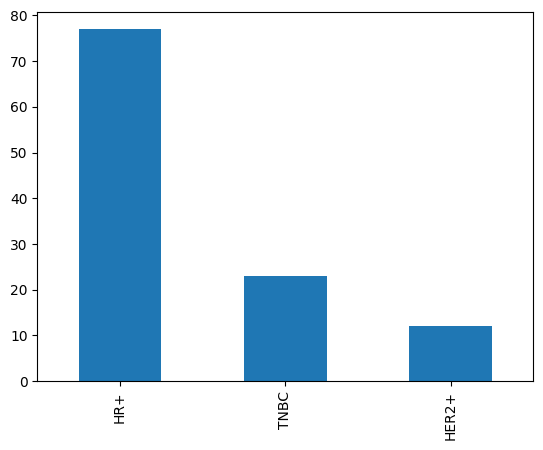

In [73]:
negative_df.loc[existing_negative_ids]['subtype'].value_counts().plot(kind="bar")